<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/Homework%205/251287809_H05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Logistic Regression with Variable Selection

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a dataset taken from USGS(U.S Geological Survey). This dataset contains earthquake data with a magnitude of 4.5+ and an "alert" warning level, recorded between 1976 and 2025. Below is an explanation of the columns included in the dataset:

- **`id`**: A unique identifier for the earthquake event.
- **`time`**: The timestamp indicating when the earthquake or event occurred, including the date and time in UTC format.
- **`latitude`**: The geographical latitude of the earthquake's epicenter, measured in degrees.
- **`longitude`**: The geographical longitude of the earthquake's epicenter, measured in degrees.
- **`depth`**: The depth at which the earthquake occurred, typically measured in kilometers below the Earth's surface.
- **`mag`**: The magnitude of the earthquake, representing the energy released by the seismic event. In this case, a value of 8.6 indicates a very large earthquake.
- **`gap`**: The azimuthal gap, which refers to the angular distance between the two most distant seismic stations that recorded the earthquake. A smaller gap typically indicates better global coverage.
- **`dmin`**: The minimum distance between the earthquake's epicenter and the nearest seismic station, measured in degrees.
- **`rms`**: The root mean square of the amplitude of the seismic waves, representing the strength of the seismic signal.
- **`horizontalError`**: The error associated with the latitude and longitude coordinates of the epicenter, typically measured in kilometers.
- **`depthError`**: The error associated with the depth measurement of the earthquake, typically measured in kilometers.
- **`magError`**: The error associated with the magnitude measurement of the earthquake, representing the uncertainty in the reported magnitude.
- **`magNst`**: The number of stations that contributed to the magnitude estimation.
- **`Alert` (target)** The alert level issued for the earthquake, whether 'Severe' or 'Non-Severe'.

The goal is to train a model for predicting the **`Alert`** which indicates the severity of the earthquake.



In [1]:
# Standard imports
import numpy as np
from itertools import chain, combinations

# Data manipulation
import pandas as pd
import polars as pl

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Download the data
!gdown https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY

Downloading...
From: https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY
To: /content/earthquakes.parquet
100% 437k/437k [00:00<00:00, 111MB/s]


# Part 1: Data Preprocessing

## Question 1.1: Load data

(1) Read the **`earthquakes.parquet`** file as a **`polars.DataFrame`** and show its descriptive statistics.

(2) Drop column **`id`** and **`time`** and display the first 5 rows of the dataframe.

Since **`id`** is unique for each earthquake event that does not contain any predictive information and **`time`** is not directly informative for predicting earthquake severity unless you extract relevant features such as time of day, seasonality, etc.

In [3]:
df = pl.read_parquet("earthquakes.parquet")
print(df.describe())

shape: (9, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ statistic ┆ id        ┆ time      ┆ latitude  ┆ … ┆ depthErro ┆ magError ┆ magNst    ┆ Alert     │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r         ┆ ---      ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str       ┆ f64       ┆   ┆ ---       ┆ f64      ┆ f64       ┆ str       │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆          ┆           ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ count     ┆ 7699      ┆ 7699      ┆ 7699.0    ┆ … ┆ 7490.0    ┆ 5485.0   ┆ 5632.0    ┆ 7699      │
│ null_coun ┆ 0         ┆ 0         ┆ 0.0       ┆ … ┆ 209.0     ┆ 2214.0   ┆ 2067.0    ┆ 0         │
│ t         ┆           ┆           ┆           ┆   ┆           ┆          ┆           ┆           │
│ mean      ┆ null      ┆ null      ┆ 0.999312  ┆ … ┆ 2.571899  ┆ 0.06792  ┆

In [4]:
df = df.drop(["id", "time"])
print(df.head(5))

shape: (5, 12)
┌───────────┬─────────────┬────────┬──────┬───┬────────────┬──────────┬────────┬────────────┐
│ latitude  ┆ longitude   ┆ depth  ┆ mag  ┆ … ┆ depthError ┆ magError ┆ magNst ┆ Alert      │
│ ---       ┆ ---         ┆ ---    ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---        │
│ f64       ┆ f64         ┆ f64    ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64    ┆ str        │
╞═══════════╪═════════════╪════════╪══════╪═══╪════════════╪══════════╪════════╪════════════╡
│ 35.59     ┆ -90.48      ┆ 15.0   ┆ 4.62 ┆ … ┆ null       ┆ null     ┆ 0.0    ┆ Non-Severe │
│ 32.998667 ┆ -115.5575   ┆ 14.19  ┆ 5.8  ┆ … ┆ 1.78       ┆ null     ┆ 0.0    ┆ Severe     │
│ 38.19     ┆ -83.95      ┆ 10.0   ┆ 5.0  ┆ … ┆ null       ┆ null     ┆ null   ┆ Non-Severe │
│ 35.816    ┆ -117.816333 ┆ 4.766  ┆ 4.7  ┆ … ┆ 31.61      ┆ 0.424    ┆ 9.0    ┆ Non-Severe │
│ 33.0955   ┆ -115.6245   ┆ 18.904 ┆ 5.75 ┆ … ┆ 0.67       ┆ 0.161    ┆ 6.0    ┆ Non-Severe │
└───────────┴─────────────┴────────┴──────┴──

## Question 1.2: Handle null values

The result of the `null_count` function indicates that some columns contain null values. Fill these null values with the median of the corresponding column and display the first 5 rows of the resulting dataframe.

In [5]:
df.null_count()

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,324,702,26,1218,209,2214,2067,0


In [10]:
# Select only numeric columns using pl.selectors.numeric()
num_cols = df.select(pl.selectors.numeric()).columns

# Fill null values in numerical columns with the median of each column
df = df.with_columns([df[col].fill_null(df[col].median()) for col in num_cols])

# Display the first 5 rows of the updated DataFrame
print(df.head(5))

shape: (5, 12)
┌───────────┬─────────────┬────────┬──────┬───┬────────────┬──────────┬────────┬────────────┐
│ latitude  ┆ longitude   ┆ depth  ┆ mag  ┆ … ┆ depthError ┆ magError ┆ magNst ┆ Alert      │
│ ---       ┆ ---         ┆ ---    ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---        │
│ f64       ┆ f64         ┆ f64    ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64    ┆ str        │
╞═══════════╪═════════════╪════════╪══════╪═══╪════════════╪══════════╪════════╪════════════╡
│ 35.59     ┆ -90.48      ┆ 15.0   ┆ 4.62 ┆ … ┆ 1.8        ┆ 0.059    ┆ 0.0    ┆ Non-Severe │
│ 32.998667 ┆ -115.5575   ┆ 14.19  ┆ 5.8  ┆ … ┆ 1.78       ┆ 0.059    ┆ 0.0    ┆ Severe     │
│ 38.19     ┆ -83.95      ┆ 10.0   ┆ 5.0  ┆ … ┆ 1.8        ┆ 0.059    ┆ 29.0   ┆ Non-Severe │
│ 35.816    ┆ -117.816333 ┆ 4.766  ┆ 4.7  ┆ … ┆ 31.61      ┆ 0.424    ┆ 9.0    ┆ Non-Severe │
│ 33.0955   ┆ -115.6245   ┆ 18.904 ┆ 5.75 ┆ … ┆ 0.67       ┆ 0.161    ┆ 6.0    ┆ Non-Severe │
└───────────┴─────────────┴────────┴──────┴──

## Question 1.3: Explore target distribution

Count the number of instances of each severity level of the earthquake in the dataset.

Comment on your findings, providing insights into the distribution of different severity levels.

In [11]:
severity_counts = df["Alert"].value_counts()
print(severity_counts)

shape: (2, 2)
┌────────────┬───────┐
│ Alert      ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ Severe     ┆ 331   │
│ Non-Severe ┆ 7368  │
└────────────┴───────┘


The dataset exhibits a significant class imbalance, with Non-Severe earthquakes (7368 instances) vastly outnumbering Severe earthquakes (331 instances). This suggests that severe earthquakes are relatively rare events, which is expected given that high-magnitude earthquakes occur less frequently than lower-magnitude ones. Such an imbalance can pose challenges for model training, as a classifier may become biased toward predicting the majority class, potentially leading to poor recall for severe earthquakes. To address this, techniques such as oversampling the minority class, undersampling the majority class, or using class-weighted logistic regression can help improve model performance and ensure that severe earthquakes are adequately recognized.

## Question 1.4: Convert target variable

Convert **`Alert`** to a binary numerical target:
- Replace **`Severe`** with 1.
- Replace **`Non-Severe`** with 0.

Display the first 5 rows of the resulting dataframe.

Hint: If you use the `replace` method, the resulting column will still be of string type. Use `cast` to make it `Float64` after replacement.

In [12]:
# Convert 'Alert' column to binary numerical target
df = df.with_columns(
    df["Alert"]
    .replace({"Severe": 1, "Non-Severe": 0})  # Replace string labels with numeric values
    .cast(pl.Float64)  # Ensure the column is of type Float64
)
print(df.head(5))

shape: (5, 12)
┌───────────┬─────────────┬────────┬──────┬───┬────────────┬──────────┬────────┬───────┐
│ latitude  ┆ longitude   ┆ depth  ┆ mag  ┆ … ┆ depthError ┆ magError ┆ magNst ┆ Alert │
│ ---       ┆ ---         ┆ ---    ┆ ---  ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---   │
│ f64       ┆ f64         ┆ f64    ┆ f64  ┆   ┆ f64        ┆ f64      ┆ f64    ┆ f64   │
╞═══════════╪═════════════╪════════╪══════╪═══╪════════════╪══════════╪════════╪═══════╡
│ 35.59     ┆ -90.48      ┆ 15.0   ┆ 4.62 ┆ … ┆ 1.8        ┆ 0.059    ┆ 0.0    ┆ 0.0   │
│ 32.998667 ┆ -115.5575   ┆ 14.19  ┆ 5.8  ┆ … ┆ 1.78       ┆ 0.059    ┆ 0.0    ┆ 1.0   │
│ 38.19     ┆ -83.95      ┆ 10.0   ┆ 5.0  ┆ … ┆ 1.8        ┆ 0.059    ┆ 29.0   ┆ 0.0   │
│ 35.816    ┆ -117.816333 ┆ 4.766  ┆ 4.7  ┆ … ┆ 31.61      ┆ 0.424    ┆ 9.0    ┆ 0.0   │
│ 33.0955   ┆ -115.6245   ┆ 18.904 ┆ 5.75 ┆ … ┆ 0.67       ┆ 0.161    ┆ 6.0    ┆ 0.0   │
└───────────┴─────────────┴────────┴──────┴───┴────────────┴──────────┴────────┴───────┘


## Question 1.5: Train test split

Split the dataset into training and testing sets:
- With **30% testing data** and **70% training data**.
- Set the **random state** to **2025**.
- Use **stratified splitting** to **maintain the same proportion of each class** in the target variable (**`Alert`**) in both the training and testing sets.

Display the descriptive statistics for X_train and X_test.

In [13]:
# Separate features (X) and target variable (y)
X = df.drop("Alert")  # Features
y = df["Alert"]  # Target

# Perform stratified train-test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=2025, stratify=y
)

# Display descriptive statistics for X_train and X_test
print("Descriptive Statistics for X_train:")
print(X_train.describe())

print("\nDescriptive Statistics for X_test:")
print(X_test.describe())

Descriptive Statistics for X_train:
shape: (9, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ statistic ┆ latitude  ┆ longitude ┆ depth     ┆ … ┆ horizonta ┆ depthErro ┆ magError ┆ magNst    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ lError    ┆ r         ┆ ---      ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64      ┆ f64       │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆          ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ count     ┆ 5389.0    ┆ 5389.0    ┆ 5389.0    ┆ … ┆ 5389.0    ┆ 5389.0    ┆ 5389.0   ┆ 5389.0    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0      ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ mean      ┆ 1.196909  ┆ 14.828723 ┆ 58

# Part 2: Sequential Feature Selection

## Question 2.1: Forward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **forward** feature selection:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Use **ROC AUC** as the scoring metric for feature selection. Conduct **5-fold cross-validation** to evaluate the model. Set the **tolerance for stopping** the selection process to **0.001**.
- Configure the logistic regression to use the default **`lbfgs`** as solver with **no penalty**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**.

Fit the pipeline and report the subset of variables on this method.


In [15]:
# Define logistic regression model with specified parameters
log_reg = LogisticRegression(
    solver="lbfgs",
    penalty=None,  # No penalty
    max_iter=1000,
    class_weight="balanced",  # Adjust weights inversely proportional to class frequencies
    random_state=2025
)

# Define a pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Standardization step
    ("sfs", SequentialFeatureSelector(
        log_reg,
        n_jobs=-1,  # Use all processors
        direction="forward",  # Forward selection
        scoring="roc_auc",  # Use ROC AUC for evaluation
        cv=5,  # 5-fold cross-validation
        tol=0.001  # Stopping criterion
    )),
])

# Fit the pipeline (feature selection only)
pipeline.fit(X_train, y_train)

# Get the selected feature names correctly
selected_features = np.array(X_train.columns)[pipeline.named_steps["sfs"].get_support()]

# Print the selected subset of variables
print("Selected Features:", selected_features)

Selected Features: ['latitude' 'depth' 'mag' 'dmin' 'horizontalError']


## Question 2.2: Backward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **backward** feature selection. Keep all other configurations the same as in the previous question

Fit the pipeline and report the subset of variables on this method.


In [16]:
# Define logistic regression model with specified parameters
log_reg = LogisticRegression(
    solver="lbfgs",
    penalty=None,  # No penalty
    max_iter=1000,
    class_weight="balanced",  # Adjusts weights inversely proportional to class frequencies
    random_state=2025
)

# Define a pipeline with backward selection
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Standardization step
    ("sfs", SequentialFeatureSelector(
        log_reg,
        n_jobs=-1,  # Use all processors
        direction="backward",  # Backward selection
        scoring="roc_auc",  # Use ROC AUC for evaluation
        cv=5,  # 5-fold cross-validation
        tol=0.001  # Stopping criterion
    )),
])

# Fit the pipeline (feature selection only)
pipeline.fit(X_train, y_train)

# Get the selected feature names correctly
selected_features_backward = np.array(X_train.columns)[pipeline.named_steps["sfs"].get_support()]

# Print the selected subset of variables
print("Selected Features (Backward Selection):", selected_features_backward)

Selected Features (Backward Selection): ['latitude' 'longitude' 'depth' 'mag' 'gap' 'dmin' 'horizontalError'
 'depthError' 'magError' 'magNst']


## Question 2.3: Compare results & find the best model

Compare and discuss the selected subset of variables obtained from both methods used in the previous steps.

Perform an **exhaustive search** over all possible subsets of the remaining variables using **5-fold cross-validation** to find the best model. Use the same Logistic Regression configurations as in previous questions.

Hint: If you have correctly followed the previous steps, you should have **five remaining variables** to evaluate in the exhaustive search.

The feature subsets obtained from forward and backward selection show key differences in how they evaluate feature importance. Forward selection, which starts with an empty model and adds features one by one based on the highest improvement in ROC AUC, resulted in a more compact subset with only 5 features: `latitude`, `depth`, `mag`, `dmin`, and `horizontalError`. This suggests that these features provide the most immediate predictive power when considered in isolation or small groups. In contrast, backward selection, which starts with all features and removes the least useful ones iteratively, retained a larger subset of 10 features, including `longitude`, `gap`, `depthError`, `magError`, and `magNst`, in addition to those selected by forward selection. This indicates that while these additional features may not have provided substantial improvements when added individually in forward selection, they still contribute meaningfully when considered in the full model. The difference in results highlights how forward selection tends to be more aggressive, favoring a parsimonious model, while backward selection is more conservative, retaining potentially redundant but collectively important features. A comparison of model performance using both subsets can help determine which approach generalizes better.

In [17]:
# Define logistic regression model with specified parameters
log_reg = LogisticRegression(
    solver="lbfgs",
    penalty=None,  # No penalty
    max_iter=1000,
    class_weight="balanced",  # Adjusts weights inversely proportional to class frequencies
    random_state=2025
)

# Selected features from forward selection
selected_features = ['latitude', 'depth', 'mag', 'dmin', 'horizontalError']

# Generate all possible feature subsets (powerset excluding empty set)
def powerset(iterable):
    """Returns all non-empty subsets of the given iterable."""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s) + 1))

# Dictionary to store results
subset_scores = {}

# Iterate over all possible feature subsets
for subset in powerset(selected_features):
    subset = list(subset)  # Convert tuple to list

    # Extract only selected subset of features
    X_train_subset = X_train[subset]
    X_test_subset = X_test[subset]

    # Perform 5-fold cross-validation and compute mean ROC AUC score
    score = np.mean(cross_val_score(log_reg, X_train_subset, y_train, cv=5, scoring="roc_auc"))

    # Store the score for this feature subset
    subset_scores[tuple(subset)] = score

# Identify the best feature subset
best_subset = max(subset_scores, key=subset_scores.get)
best_score = subset_scores[best_subset]

# Print the best subset and its ROC AUC score
print("Best Feature Subset:", best_subset)
print("Best ROC AUC Score:", best_score)

Best Feature Subset: ('latitude', 'depth', 'mag', 'dmin', 'horizontalError')
Best ROC AUC Score: 0.8893833264825519


## Question 2.4: Fit the best model

Train a logistic regression model with the best variables selected.

Display the model's coefficients and intercept.

In [18]:
# Extract the best subset of features
X_train_best = X_train[list(best_subset)]
X_test_best = X_test[list(best_subset)]

# Train the final logistic regression model
final_model = LogisticRegression(
    solver="lbfgs",
    penalty=None,  # No penalty
    max_iter=1000,
    class_weight="balanced",  # Adjusts weights inversely proportional to class frequencies
    random_state=2025
)

final_model.fit(X_train_best, y_train)

# Display model coefficients and intercept
print("Intercept:", final_model.intercept_[0])
print("Coefficients:")

# Mapping feature names to coefficients
for feature, coef in zip(best_subset, final_model.coef_[0]):
    print(f"{feature}: {coef}")

Intercept: -13.654766677001279
Coefficients:
latitude: 0.03451549260760152
depth: -0.02279378890337942
mag: 2.571071674381321
dmin: -0.1564821658350278
horizontalError: -0.1430463621513815


## Question 2.5: Measure model's performance

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [21]:
np.random.seed(2025) # DO NOT DELETE

# Number of bootstrap resamples
n_bootstraps = 100

# Store bootstrap accuracy and AUC scores
bootstrap_acc = []
bootstrap_auc = []

# Convert Polars DataFrame to Pandas (since scikit-learn needs Pandas or NumPy)
X_test_best_pd = X_test_best.to_pandas()
y_test_pd = y_test.to_pandas()

# Perform bootstrap resampling
for _ in range(n_bootstraps):
    # Sample test set with replacement using NumPy
    indices = np.random.choice(len(X_test_best_pd), size=len(X_test_best_pd), replace=True)
    X_test_sample = X_test_best_pd.iloc[indices]
    y_test_sample = y_test_pd.iloc[indices]

    # Predict on bootstrap sample
    y_pred = final_model.predict(X_test_sample)
    y_pred_proba = final_model.predict_proba(X_test_sample)[:, 1]  # Probabilities for ROC AUC

    # Compute accuracy and AUC
    bootstrap_acc.append(accuracy_score(y_test_sample, y_pred))
    bootstrap_auc.append(roc_auc_score(y_test_sample, y_pred_proba))

# Compute 95% confidence intervals
acc_ci = (np.percentile(bootstrap_acc, 2.5), np.percentile(bootstrap_acc, 97.5))
auc_ci = (np.percentile(bootstrap_auc, 2.5), np.percentile(bootstrap_auc, 97.5))

# Display results
print(f"95% CI for Accuracy: {acc_ci}")
print(f"95% CI for AUC: {auc_ci}")

95% CI for Accuracy: (0.7835281385281385, 0.8132142857142857)
95% CI for AUC: (0.8456320770483267, 0.902112446730215)


# Part 3: Regularization

## Question 3.1: Ridge penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Ridge penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [23]:
np.random.seed(2025) # DO NOT DELETE

# Define logistic regression with Ridge penalty using LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(
    solver="saga",  # Supports Ridge (L2) regularization
    Cs=10,  # Default Cs (inverse of regularization strength)
    max_iter=1000,
    class_weight="balanced",  # Adjust weights inversely proportional to class frequencies
    cv=5,  # 5-fold cross-validation
    random_state=2025
)

# Define a pipeline for standardization + logistic regression
pipeline_cv = Pipeline([
    ("scaler", StandardScaler()),  # Standardization step
    ("log_reg", log_reg_cv)  # Logistic Regression with cross-validation
])

# Fit the pipeline
pipeline_cv.fit(X_train_best, y_train)

# Best model is stored in pipeline_cv.named_steps["log_reg"]
best_model = pipeline_cv.named_steps["log_reg"]

# Display best regularization strength (C) selected
print("Best Regularization Strength (C):", best_model.C_)

# Number of bootstrap resamples
n_bootstraps = 100

# Store bootstrap accuracy and AUC scores
bootstrap_acc = []
bootstrap_auc = []

# Convert Polars DataFrame to Pandas (for scikit-learn compatibility)
X_test_best_pd = X_test_best.to_pandas()
y_test_pd = y_test.to_pandas()

# Perform bootstrap resampling
for _ in range(n_bootstraps):
    # Sample test set with replacement
    indices = np.random.choice(len(X_test_best_pd), size=len(X_test_best_pd), replace=True)
    X_test_sample = X_test_best_pd.iloc[indices]
    y_test_sample = y_test_pd.iloc[indices]

    # Predict on bootstrap sample
    y_pred = pipeline_cv.predict(X_test_sample)
    y_pred_proba = pipeline_cv.predict_proba(X_test_sample)[:, 1]  # Probabilities for ROC AUC

    # Compute accuracy and AUC
    bootstrap_acc.append(accuracy_score(y_test_sample, y_pred))
    bootstrap_auc.append(roc_auc_score(y_test_sample, y_pred_proba))

# Compute 95% confidence intervals
acc_ci = (np.percentile(bootstrap_acc, 2.5), np.percentile(bootstrap_acc, 97.5))
auc_ci = (np.percentile(bootstrap_auc, 2.5), np.percentile(bootstrap_auc, 97.5))

# Display results
print(f"95% CI for Accuracy: {acc_ci}")
print(f"95% CI for AUC: {auc_ci}")

Best Regularization Strength (C): [0.0001]
95% CI for Accuracy: (0.7927813852813853, 0.8210064935064935)
95% CI for AUC: (0.8278623267934919, 0.8870706828691398)


## Question 3.2: Lasso penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Lasso penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [24]:
np.random.seed(2025) # DO NOT DELETE

# Define logistic regression with Lasso (L1) penalty using LogisticRegressionCV
log_reg_lasso = LogisticRegressionCV(
    solver="saga",  # SAGA solver supports L1 (Lasso) regularization
    penalty="l1",  # Lasso (L1) regularization
    Cs=10,  # Default Cs (inverse of regularization strength)
    max_iter=1000,
    class_weight="balanced",  # Adjust weights inversely proportional to class frequencies
    cv=5,  # 5-fold cross-validation
    random_state=2025
)

# Define a pipeline for standardization + logistic regression
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),  # Standardization step
    ("log_reg", log_reg_lasso)  # Logistic Regression with Lasso
])

# Fit the pipeline
pipeline_lasso.fit(X_train_best, y_train)

# Best model is stored in pipeline_lasso.named_steps["log_reg"]
best_lasso_model = pipeline_lasso.named_steps["log_reg"]

# Display best regularization strength (C) selected
print("Best Regularization Strength (C):", best_lasso_model.C_)

# Number of bootstrap resamples
n_bootstraps = 100

# Store bootstrap accuracy and AUC scores
bootstrap_acc = []
bootstrap_auc = []

# Convert Polars DataFrame to Pandas (for scikit-learn compatibility)
X_test_best_pd = X_test_best.to_pandas()
y_test_pd = y_test.to_pandas()

# Perform bootstrap resampling
for _ in range(n_bootstraps):
    # Sample test set with replacement
    indices = np.random.choice(len(X_test_best_pd), size=len(X_test_best_pd), replace=True)
    X_test_sample = X_test_best_pd.iloc[indices]
    y_test_sample = y_test_pd.iloc[indices]

    # Predict on bootstrap sample
    y_pred = pipeline_lasso.predict(X_test_sample)
    y_pred_proba = pipeline_lasso.predict_proba(X_test_sample)[:, 1]  # Probabilities for ROC AUC

    # Compute accuracy and AUC
    bootstrap_acc.append(accuracy_score(y_test_sample, y_pred))
    bootstrap_auc.append(roc_auc_score(y_test_sample, y_pred_proba))

# Compute 95% confidence intervals
acc_ci = (np.percentile(bootstrap_acc, 2.5), np.percentile(bootstrap_acc, 97.5))
auc_ci = (np.percentile(bootstrap_auc, 2.5), np.percentile(bootstrap_auc, 97.5))

# Display results
print(f"95% CI for Accuracy: {acc_ci}")
print(f"95% CI for AUC: {auc_ci}")

Best Regularization Strength (C): [0.35938137]
95% CI for Accuracy: (0.7833225108225108, 0.8127813852813853)
95% CI for AUC: (0.8455077979180496, 0.9022788418730096)


## Question 3.3: Ridge vs Lasso

Report the coefficients from the best-performing models with Ridge and Lasso penalties.

Compare and discuss how the coefficient magnitudes differ between Ridge and Lasso, and explain.

In [26]:
# Get feature names
feature_names = X_train_best.columns

# Extract coefficients from Ridge model
ridge_coefs = best_model.coef_.flatten()

# Extract coefficients from Lasso model
lasso_coefs = best_lasso_model.coef_.flatten()

# Create DataFrame to compare coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Ridge Coefficient": ridge_coefs,
    "Lasso Coefficient": lasso_coefs
})

# Sort by absolute value of Ridge coefficients for better readability
coef_df["Abs Ridge"] = coef_df["Ridge Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs Ridge", ascending=False).drop(columns=["Abs Ridge"])

# Display the coefficients
print(coef_df.to_string(index=False))

        Feature  Ridge Coefficient  Lasso Coefficient
            mag           0.129077           1.307781
       latitude           0.078482           1.114032
horizontalError          -0.061254          -0.379603
           dmin          -0.044217          -0.766423
          depth          -0.038796          -2.588225


The coefficient magnitudes differ significantly between Ridge and Lasso due to their distinct regularization approaches. Ridge regression (L2 penalty) distributes the shrinkage evenly across all features, ensuring that no coefficient is completely eliminated but rather scaled down proportionally. This results in smaller coefficient magnitudes overall, as seen in the relatively low absolute values for all features. On the other hand, Lasso regression (L1 penalty) performs feature selection by shrinking some coefficients aggressively, pushing weaker ones toward zero, and allowing a few key features to have larger absolute values. In this case, Lasso assigned much higher importance to `mag (1.3078)`, `latitude (1.1140)`, and `depth (-2.5882)` compared to Ridge, indicating that these features play a dominant role in classification. The greater absolute magnitudes suggest that Lasso forces the model to rely more heavily on fewer predictors, making it sparser and potentially more interpretable. In contrast, Ridge maintains a more balanced, conservative approach, retaining information across all features rather than emphasizing only a few.

# Part 4: Overall Comparison

Compare the best models obtained using **Sequential Feature Selection**, **Ridge Regularization**, and **Lasso Regularization** by plotting the ROC curve for each model on a single plot. Additionally, include a diagonal reference line representing random classification performance (i.e., an ROC curve with an AUC of 0.5).

Provide a brief analysis and comment on your findings (no need to identify the best model).

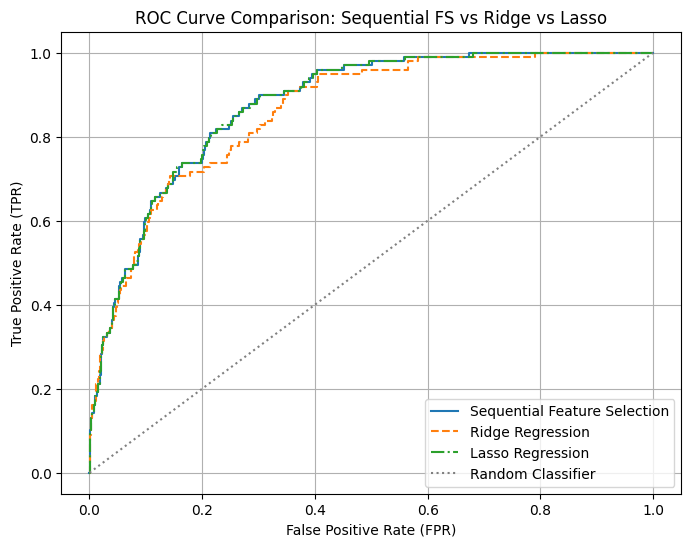

In [28]:
# Get predicted probabilities for each model
y_pred_proba_sfs = final_model.predict_proba(X_test_best)[:, 1]  # Sequential Feature Selection model
y_pred_proba_ridge = pipeline_cv.predict_proba(X_test_best)[:, 1]  # Ridge model
y_pred_proba_lasso = pipeline_lasso.predict_proba(X_test_best)[:, 1]  # Lasso model

# Compute ROC curves
fpr_sfs, tpr_sfs, _ = roc_curve(y_test, y_pred_proba_sfs)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_pred_proba_ridge)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_pred_proba_lasso)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_sfs, tpr_sfs, label="Sequential Feature Selection", linestyle='-')
plt.plot(fpr_ridge, tpr_ridge, label="Ridge Regression", linestyle='--')
plt.plot(fpr_lasso, tpr_lasso, label="Lasso Regression", linestyle='-.')

# Random classifier reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='dotted', label="Random Classifier")

# Labels and legend
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison: Sequential FS vs Ridge vs Lasso")
plt.legend(loc="lower right")
plt.grid(True)

# Show plot
plt.show()

The ROC curve comparison highlights that all three models—Sequential Feature Selection (SFS), Ridge Regression, and Lasso Regression—perform significantly better than a random classifier, demonstrating strong predictive capabilities for distinguishing between Severe and Non-Severe earthquakes. The curves for SFS and Lasso regression closely follow each other, suggesting that both approaches effectively identify key predictive features while maintaining model flexibility. Ridge regression, while still performing well, appears slightly below the others in some regions, indicating that retaining all features with small weight adjustments may not always be the most optimal strategy. The overall high True Positive Rate (TPR) with relatively low False Positive Rate (FPR) across all models suggests that the dataset contains strong predictive signals for earthquake severity. However, the trade-off between feature selection (Lasso, SFS) and full regularization (Ridge) implies that different modeling approaches can yield similar performance while affecting interpretability and model complexity differently.